In [2]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
mp.rcParams['axes.linewidth'] = 1
font_legend = 15; font_axes=15
# %matplotlib inline
from joblib import  Memory

import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

In [3]:
FONTSIZE=18
font = {'family': 'serif', 'weight':'normal', 'size':FONTSIZE}
mp.rc('font', **font)
mp.rc('text',usetex=True)

In [4]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
def debug(func):
    """Print the function signature and return value"""
    import functools

    @functools.wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]
        signature = ", ".join(args_repr + kwargs_repr)
        print(f"Calling {func.__name__}({signature})")
        values = func(*args, **kwargs)
        print(f"{func.__name__!r} returned {values!r}")
        return values

    return wrapper_debug

def theta_hat_func(n,m, MLE):
       #n,m are integer arrays
    if MLE:
        theta_hat = n-m
    else:
        # non-MLE
        # theta_hat = n-m
        # theta_hat = (theta_hat) * (theta_hat > 0)
        theta_hat = np.where(n>m, n-m, 0)
         
    return theta_hat


def L_prof_global(n,m, MLE):
    #n,m integer arrays
    # nu_hat = m, if theta_hat = theta_hat_MLE
    # nu_hat  =  (m+n)/2 if theta_hat = n-m
    # nu_hat = 0  if theta_hat != n-m
    theta_hat=theta_hat_func(n,m,MLE)
    # print('n-m ',  n-m)
    if MLE:
        # i.e. if theta_hat = n-m
        # assert theta_hat==n-m
        nu_hat = m
    else:
        nu_hat = np.where(theta_hat ==0, (m+n)/2, m)

    p1=st.poisson.pmf(n, theta_hat+nu_hat)
    p2 = st.poisson.pmf(m, nu_hat)
    return p1*p2

def L_theta_nu(n,m,theta,nu):
    p1 = st.poisson.pmf(n, theta+nu)
    p2 = st.poisson.pmf(m, nu)
    return p1*p2
def lambda_test_2d(n,m, theta, nu, MLE):
    Ln= L_theta_nu(n,m,theta,nu)
    
    Ld= L_prof_global(n,m, MLE)
    eps=1e-20
    Ld=Ld+eps
    lambda_  = -2*np.log(Ln/Ld)
    return np.array(lambda_)

In [6]:
def D(Nmin, Nmax, Mmin, Mmax):
    return [(n,m) for N in range(Nmin, Nmax) for m in range(Mmin, Mmax)]


In [7]:
def save_model(model, PARAMS, pth_string):
    """pth string is the name of the pth file which is a dictionary of dictionaries"""
    models_path = os.path.join(os.getcwd(), '../models')
    PATH=os.path.join(models_path, pth_string)
    print(f'saving model with th string : {pth_string}\n')
    torch.save({'PARAMS': PARAMS,
                'model_state_dict': model.state_dict()},
                PATH)
    print(model)

In [8]:
def make_binned_X(X_min, X_max, Nbins):
    X_step = (X_max-X_min) / Nbins
    bins = np.arange(X_min, X_max+X_step, X_step)
    bin_centers = (bins[1:] + bins[:-1])/2
    return np.array(bin_centers)

def make_eval_data_2d_with_NM(Bprime, N, M, nbins_theta, nbins_nu):
    """Make evaluation data composed of: binned theta and nu, and discrete N and M,
    and optionally theta_hat. The theta hat argument accpts an MLE boolean, therefore
    if trained on MLE data, the theta_hat that we use for evaluation is just 
    n-m, including negative values.
    The return value of this function is used as the "eval_data" tensor below
    
    with lambda_D or with NM"""
    #if MLE true, load the model that was trained on MLE data and vice versa
    # N, M = D
    # nbins=NBINS
    # thetamin,thetamax=0,20
    train_df = load_2d_train_df(MLE=False, with_lambda_D=True)
    
    THETA_bin_centers = make_binned_X(X_min=train_df['theta'].min(),
                                      X_max=train_df['theta'].max(), 
                                      Nbins=nbins_theta)
        
    NU_bin_centers = make_binned_X(X_min=train_df['nu'].min(),
                                  X_max=train_df['nu'].max(), 
                                  Nbins=nbins_nu)
        
    # tensor = torch.Tensor([
                           # [x, y, theta_hat(N, M, MLE=True), N, M] 
                           # for (x,y) in zip(THETA_bin_centers,NU_bin_centers)
                          # ])

    tensor = torch.Tensor([
                       [x, y, theta_hat(N, M, MLE=True), N, M] 
                       for x in THETA_bin_centers for y in NU_bin_centers
                      ])

    #zip only traverses the lists monotonically, so experiment to use cross to take every combination of the two lists
    
    return tensor, THETA_bin_centers.ravel(), NU_bin_centers.ravel()

In [9]:
class SiLURegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.SiLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                layers.append(nn.SiLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

In [10]:
@debug
def load_untrained_model(PARAMS):
    """Load an untrained model (with weights initiatted) according to model paramateters in the 
    PARAMS dictionary

    Args:
        PARAMS (dict): dictionary of model/training parameters: i.e. hyperparameters and training parameters.

    Returns:
        utils.RegularizedRegressionModel object
    """
    model = SiLURegressionModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"],
        # activation=PARAMS["activation"]
    )
    # model.apply(initialize_weights)
    print('INITIATED UNTRAINED MODEL:',
          # model
         )
    # print(model)
    return model
    

# Step 1: define model parameters for MLE=False model

In [11]:
PARAMS_lambdaD_nonMLE_SILU = {
"n_layers": int(12),
"hidden_size": int(12),
"dropout": float(0.13),
"NFEATURES":int(3),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.0006),
'momentum':float(0.9),
'batch_size':int(256*2),
'n_iterations': int(1e5),
'traces_step':int(100),
'L2':float(0.1),
'MLE':False,
'with_lambda_D':True,
'pth_string':'FEB_20_model_lambda_D_nonMLE_SILU.pth'
}

# step 2: load untrained model for MLE=False

In [12]:
untrained_SiLU_model_nonMLE = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

Calling load_untrained_model({'n_layers': 12, 'hidden_size': 12, 'dropout': 0.13, 'NFEATURES': 3, 'activation': 'SiLU', 'optimizer_name': 'NAdam', 'starting_learning_rate': 0.0006, 'momentum': 0.9, 'batch_size': 512, 'n_iterations': 100000, 'traces_step': 100, 'L2': 0.1, 'MLE': False, 'with_lambda_D': True, 'pth_string': 'FEB_20_model_lambda_D_nonMLE_SILU.pth'})
INITIATED UNTRAINED MODEL:
'load_untrained_model' returned SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (1

# Step 3: Load Trained model for MLE=False

In [13]:
def load_model(model, PARAMS, pth_string):
    models_path = os.path.join(os.getcwd(), '../models')
    PATH=os.path.join(models_path, pth_string)
    model = SiLURegressionModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"]
    )
    checkpoint = torch.load(PATH)
    print('INITIATED MODEL:',  model)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'loading model with th string : {pth_string}\n')    
    print(model)
    
    return model

In [14]:
# untrained_SiLU_model = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

trained_SiLU_model_nonMLE = load_model(model = untrained_SiLU_model_nonMLE, 
                                PARAMS=PARAMS_lambdaD_nonMLE_SILU,
                   pth_string=PARAMS_lambdaD_nonMLE_SILU["pth_string"])

INITIATED MODEL: SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (13): Dropout(p=0.13, inplace=False)
    (14): SiLU()
    (15): Linear(in_features=12, out_features=12, bias=True)
    (16): Dropout(p=0.13, inplace=False)
    (17): SiLU()
    (18): Linear(in_features=12, out_features=12, bias=True)
    (19): Dropout(p=0.13, inplace=False)
    (20): SiLU()
    (21): Linear(in_features=12, out_features=12, bias=True)
    (22): Dropout(p=0.13, inplace=False)
    (23): SiLU(

# Step 4: define model parameters for MLE=True model

In [15]:
PARAMS_lambdaD_MLE_SILU = {
"n_layers": int(12),
"hidden_size": int(12),
"dropout": float(0.13),
"NFEATURES":int(3),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.0006),
'momentum':float(0.9),
'batch_size':int(256*2),
'n_iterations': int(6e4),
'traces_step':int(100),
'L2':float(0.1),
'MLE':True,
'with_lambda_D':True,
'pth_string':'FEB_20_model_lambda_D_MLE_SILU.pth'
}

# step 5: load untrained model for MLE=True

In [16]:
untrained_SiLU_model_MLE = load_untrained_model(PARAMS_lambdaD_MLE_SILU)

Calling load_untrained_model({'n_layers': 12, 'hidden_size': 12, 'dropout': 0.13, 'NFEATURES': 3, 'activation': 'SiLU', 'optimizer_name': 'NAdam', 'starting_learning_rate': 0.0006, 'momentum': 0.9, 'batch_size': 512, 'n_iterations': 60000, 'traces_step': 100, 'L2': 0.1, 'MLE': True, 'with_lambda_D': True, 'pth_string': 'FEB_20_model_lambda_D_MLE_SILU.pth'})
INITIATED UNTRAINED MODEL:
'load_untrained_model' returned SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (13): D

# Step 6: Load Trained model for MLE=True

In [17]:
# untrained_SiLU_model = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

trained_SiLU_model_MLE = load_model(model = untrained_SiLU_model_MLE, 
                                PARAMS=PARAMS_lambdaD_MLE_SILU,
                   pth_string=PARAMS_lambdaD_MLE_SILU["pth_string"])

INITIATED MODEL: SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (13): Dropout(p=0.13, inplace=False)
    (14): SiLU()
    (15): Linear(in_features=12, out_features=12, bias=True)
    (16): Dropout(p=0.13, inplace=False)
    (17): SiLU()
    (18): Linear(in_features=12, out_features=12, bias=True)
    (19): Dropout(p=0.13, inplace=False)
    (20): SiLU()
    (21): Linear(in_features=12, out_features=12, bias=True)
    (22): Dropout(p=0.13, inplace=False)
    (23): SiLU(

# Summary: We have loaded `trained_SiLU_model_nonMLE` and `trained_SiLU_model_MLE`

In [18]:
class TrainedModel:
    def __init__(self, model):
        self.model = model

    def __cdf(self, x):
        # convert to a tensor and compute
 
        X = torch.Tensor(x)#.transpose(1, 0)
            
        X.requires_grad_(True)
        
        self.model.eval() 
        
        return self.model(X), X 
        
    def cdf(self, x): 
        F, _ = self.__cdf(x)
        
        Y = F.view(-1).detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y

        
        Y = F.view(-1).detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y
    
    def numerical_deriv(self,x):
        h=1E-3
        F_h = self.cdf(x+h)
        F = self.cdf(x)
        deriv = (F_h-F)/h
        return deriv
        

    def pdf(self, x):
        F, X = self.__cdf(x)

        dFdX = torch.autograd.grad(outputs=F, inputs=X, 
                               grad_outputs=torch.ones_like(F),
                               #allow_unused=True, 
                               #retain_graph=True, 
                               create_graph=True)[0]
    
        # Y = dFdX.view(-1).detach().numpy()
        Y = dFdX.detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y.T[-1]  


In [52]:

def run_sim(theta, nu, MLE, lambda_size):
    """Sample n ~ Pois(theta+nu), 
              m ~ Pois(nu), 
    and compute 
              lambda(theta, n, m)
              
    return: (n, m, lambda_), where each are np arrays of length lambda_size
    """
    n = st.poisson.rvs(theta+nu, size=lambda_size)
    m = st.poisson.rvs(nu, size=lambda_size)
    lambda_ = lambda_test_2d(theta=theta, nu=nu, n=n, m=m, MLE=MLE)
    return (n, m, lambda_)

def run_sims(points, MLE):
    """
    Run an entire simulation, that is, generate n and m from 
    run_sim above, and calculate lambda, for
    
    input: a tuple of (theta, nu) scalars
    
    Reurns:df, lambda_results
    
    where lambda_results is a list of tuples 
        (n, m, lambda_, theta, nu)
    and df is just a dataframe of [n,m,lambda,theta,nu]

    """
    lambda_results=[]
    df=pd.DataFrame()
    for p in points:
        theta, nu = p
        df['theta']=theta
        df['nu']=nu
        n, m, lambda_ = run_sim(theta, nu, MLE, lambda_size =chi2_exp_size)
        df['n'] = n
        df['m'] = m
        df['lambda']=lambda_
        lambda_results.append((n, m, lambda_, theta, nu))
    
        print( '\n \n (theta, nu) =  (%.f, %.f) \n ' % (theta, nu) )
        print(f'\t \t with associated n =  {n}, \n \n \t \t m = {m}, \n \n \t \t lambda = {lambda_}'  )
    return df, lambda_results

def plot_all(lambda_, theta, nu, ax_l, MLE):
    """Histogram the CDF of  lambda_t = -2log(Lp(theta)/Lp(theta_hat)), 
    for a given (fixed) theta and nu.
    Also, plot the actual CDF of a chi^2 distribution with 1 free parameter 
    (since only theta is left after we profile nu) """
    ftsize = 16; xmin= 0; xmax= 10
    ymin= 0; ymax= 1
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    # X = np.empty((len(lambda_), 3))
    # X[:,0] = np.ones_like(theta)*theta
    # X[:,1] = np.ones_like(nu)*nu
    
    # X[:,2] = np.linspace(0,10,len(lambda_))
    BINS=30
    if MLE==True:
        tmodel = TrainedModel(trained_SiLU_model_MLE)
    else:
        tmodel = TrainedModel(trained_SiLU_model_nonMLE)
        
    
    ax_l[0].set_ylabel(r'$F(\lambda)$', fontsize=ftsize)
    ##########HISTOGRAM CDF OF LAMBDA####################
    
    yc, low_edge, _ = ax_l[0].hist(lambda_, bins=BINS, range=x_range,
    color=(0.8,0.8,0.9),
    density=True, cumulative=True,
    histtype='stepfilled', edgecolor='black', label=r'$F(\lambda)$')
    print(yc, low_edge)
    ############################################################
    ########### HISTOGRAM CDF OF THE CHI2 OF OF X WITH 1 DOF
    #x is not theta, that's the whole point of Wilks thm, x is an arbitrary RV

    x = (low_edge[1:]+low_edge[:-1])/2
    #x = np.arange(0, xmax, 0.2)
    assert(len(x) == len(yc))
    
    y = st.chi2.cdf(x, 2)
    ax_l[0].plot(x, y, color='green',
    linewidth=2, label=r'$F(\chi^2_2)$')


    X = np.empty((len(x), 3))
    X[:,0] = np.ones_like(theta)*theta
    X[:,1] = np.ones_like(nu)*nu
    X[:,2] = np.linspace(0, low_edge[-1],len(x))
    
    cdf = tmodel.cdf(X)

    assert(len(cdf) == len(yc))

    res = cdf - yc
    
    ax_l[0].plot(X[:,2], cdf, label='$\hat{F}(\lambda)$', color='red')
    
    ax_l[1].set_ylabel(r'$f(\lambda)$', fontsize=ftsize)
    ax_l[1].hist(lambda_, bins=BINS, range=x_range,density=True,
    color=(0.8,0.8,0.9),
    histtype='stepfilled', edgecolor='black', label=r'$f(\lambda)$')
    
    #x = np.arange(0, xmax, 0.2)
    y = st.chi2.pdf(x, 2)
    ax_l[1].plot(x, y, color='green',
    linewidth=2, label=r'$f(\chi^2_2)$')
    
    ax_l[2].set_ylabel(r'$f(\lambda)= \partial \hat{F} / \partial \lambda$', fontsize=ftsize)
    ax_l[2].hist(lambda_, bins=BINS, range=x_range,density=True,
    color=(0.8,0.8,0.9),
    histtype='stepfilled', edgecolor='black', 
                 label=r'$f(\lambda)$'
                )


    pdf = tmodel.pdf(X)
    
    pdf_deriv = tmodel.numerical_deriv(X)
    ax_l[2].plot(X[:,2], pdf, label='$\partial \hat{F} / \partial \lambda$', color = 'r', linestyle='--' )
    ax_l[2].plot(X[:,2], pdf_deriv, label='numerical $\partial \hat{F} / \partial \lambda$', color='black', linestyle='--')
    
    ############################################################
    
    # annotate
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + 3*xwid
    ypos = ymin + ywid*2
    for i in range(len(ax_l)):
        ax_l[i].set_xlim(x_range); ax_l[i].set_ylim(y_range)
        ax_l[i].set_xlabel(r'$\lambda \left(\mu,\nu \mid n, m \right)$',fontsize=ftsize-2)
        ax_l[i].text(xpos, ypos,
        r'$ \mu = %.2f, \nu = %.2f$' % (theta, nu),
        fontsize=ftsize-3)
        ax_l[i].legend(loc='upper right',fontsize=13)
        
    return x, res

[0.16648768 0.28664882 0.3918333  0.50050166 0.57585383 0.63812506
 0.69638554 0.72960593 0.74381876 0.81716429 0.84291779 0.86994686
 0.89259965 0.908504   0.92256809 0.93571709 0.94193867 0.94692501
 0.96013452 0.96290246 0.96623005 0.97035676 0.97349528 0.97707747
 0.98828791 0.99120963 0.99430781 0.99772111 0.99941263 1.        ] [ 0.          0.33333333  0.66666667  1.          1.33333333  1.66666667
  2.          2.33333333  2.66666667  3.          3.33333333  3.66666667
  4.          4.33333333  4.66666667  5.          5.33333333  5.66666667
  6.          6.33333333  6.66666667  7.          7.33333333  7.66666667
  8.          8.33333333  8.66666667  9.          9.33333333  9.66666667
 10.        ]
30 30


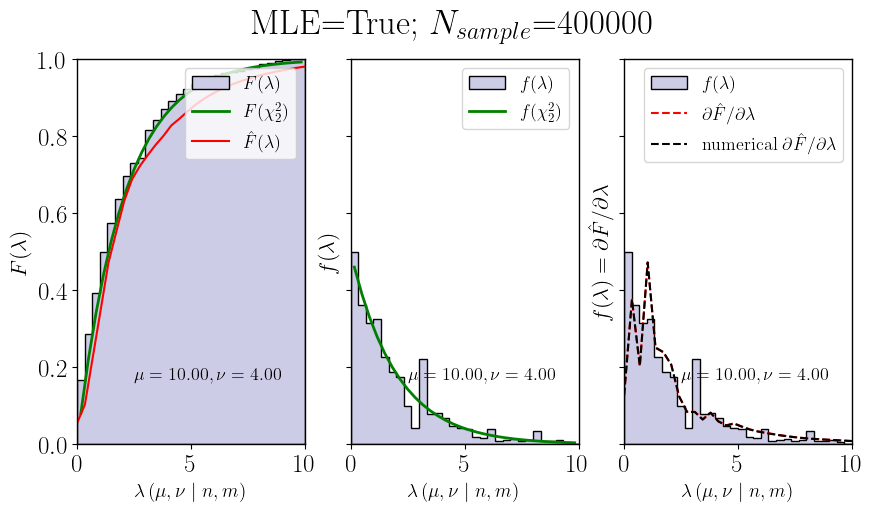

In [53]:
#points=(theta,nu)
chi2_exp_size=400000

points_1 = (10, 4)

MLE=True
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)

# plt.subplots_adjust(wspace=0.3)
# plot_one(lambda_1, points_1[0], points_1[1], ax)
x_res, y_res = plot_all(lambda_1, points_1[0], points_1[1], ax, MLE=MLE)

print(len(x_res), len(y_res))

fig.suptitle(r'MLE=%s; $N_{sample}$=%s' % \
             (  str(MLE), str(int(chi2_exp_size))), fontsize=25); 



SAVE=True
if SAVE:
    plt.savefig('../images/Wilk_agreement_MLE_%s_N_%s.pdf' % (str(MLE), str(chi2_exp_size) ), dpi=100)
plt.show()

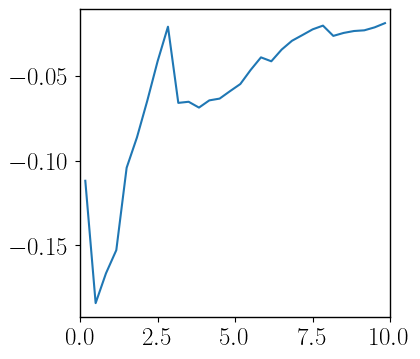

In [54]:
def plot_residuals(x, y, xmin=0, xmax=10):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
    ax.set_xlim(xmin, xmax)
    ax.plot(x, y)
plot_residuals(x_res, y_res)

[0.07883687 0.20906048 0.30550515 0.39256621 0.43836514 0.5082116
 0.57622317 0.63781518 0.66504602 0.71854994 0.72933491 0.74376695
 0.77797689 0.83042979 0.84622539 0.87051236 0.87825515 0.89974191
 0.91136114 0.92232002 0.93102562 0.93873565 0.94357237 0.9469422
 0.95557471 0.96069373 0.96411901 0.96577493 0.96943209 0.97073516
 0.97461916 0.97659519 0.98349615 0.98879664 0.99281674 0.99391566
 0.99650919 0.99859107 0.999569   1.        ] [ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.  ]


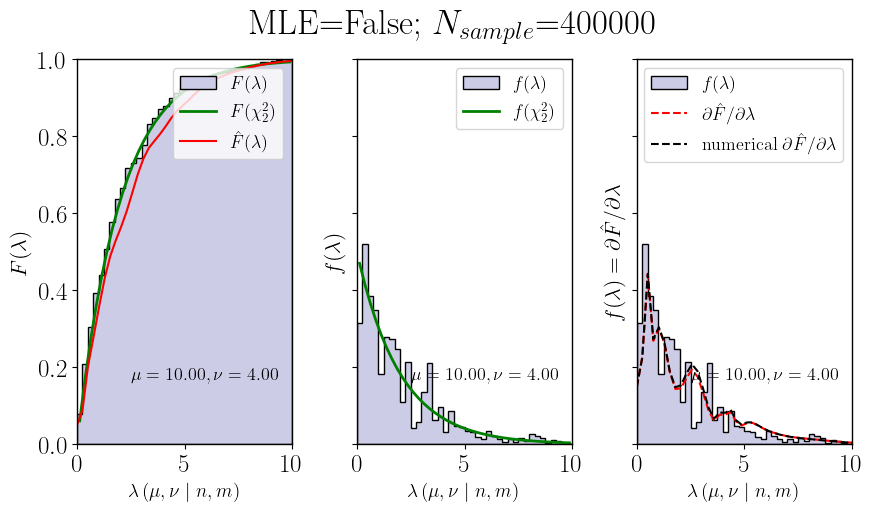

In [48]:
#points=(theta,nu)
chi2_exp_size=400000

points_1 = (10, 4)

MLE=False
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)

plt.subplots_adjust(wspace=0.3)
# plot_one(lambda_1, points_1[0], points_1[1], ax)
plot_all(lambda_1, points_1[0], points_1[1], ax, MLE=MLE)

fig.suptitle(r'MLE=%s; $N_{sample}$=%s' % \
             (  str(MLE), str(int(chi2_exp_size))), fontsize=25); 



SAVE=True
if SAVE:
    plt.savefig('../images/Wilk_agreement_MLE_%s_N_%s.pdf' % (str(MLE), str(chi2_exp_size) ))
plt.show()

# Make training data

In [59]:
def generate_X(theta, nu, N_points, MLE):
    N = st.poisson.rvs(theta+nu, size=N_points)
    M = st.poisson.rvs(nu, size=N_points)
    lambda_D = lambda_test_2d(N, M, theta, nu, MLE).flatten()
    X = np.empty((N_points, 3))
    X[:,0] = np.ones_like(theta)*theta
    X[:,1] = np.ones_like(nu)*nu
    X[:,2]  = lambda_D
    return X

def precision(arr):
    return [float(int(100000*x))/100000 for x in arr]

def cdf(lst, x):

    count = sum(1 for num in lst if num <= x)
    return count / len(lst)

In [67]:
help(np.cumsum)

Help on _ArrayFunctionDispatcher in module numpy:

cumsum(a, axis=None, dtype=None, out=None)
    Return the cumulative sum of the elements along a given axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        Axis along which the cumulative sum is computed. The default
        (None) is to compute the cumsum over the flattened array.
    dtype : dtype, optional
        Type of the returned array and of the accumulator in which the
        elements are summed.  If `dtype` is not specified, it defaults
        to the dtype of `a`, unless `a` has an integer dtype with a
        precision less than that of the default platform integer.  In
        that case, the default platform integer is used.
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output
        but the type will be cast if necessary. See :ref:`ufuncs-output-

In [85]:
def coarse_grain_lambda(lambda_, theta, nu, xbins=25, xmin=0, xmax=10):
    Y, edges = np.histogram(lambda_, bins=xbins, range=(xmin, xmax), density=True)
    h = edges[1]-edges[0]
    Y = np.cumsum(Y) * h
    x = (edges[1:]+edges[:-1])/2
    X = np.empty((len(x), 3))
    X[:,0] = np.ones_like(theta)*theta
    X[:,1] = np.ones_like(nu)*nu
    X[:,2] = np.linspace(0, edges[-1],len(x))
    return Y, X

In [86]:
# t = 10
# n = 4
# X = generate_X(theta=t, nu=n, N_points=1000, MLE=False)
# lambda_ = X[:,2].flatten()
# Y, X = coarse_grain_lambda(lambda_, t, n)
# Y

In [101]:
tmodel = TrainedModel(trained_SiLU_model_nonMLE)

def generate_theta_nu_single_point_coarse_grain(tmodel, theta, nu, N_points=5000, xbins=25, xmin=0, xmax=10):
    """non MLE evaluation data for the correction function at a single theta, nu point"""


    X = generate_X(theta=theta, nu=nu, N_points=N_points, MLE=False)
    lambda_ = X[:,2].flatten()
    lambda_ = precision(lambda_)
    Y, X = coarse_grain_lambda(lambda_, theta, nu, xbins, xmin, xmax)
    a = tmodel.cdf(X)
    assert(len(a) == len(Y))
    
    res = a - Y
    d = []
    for l, r in zip(lambda_, res):
        d.append([theta, nu, l, r])
    return d

In [105]:
Npoints = 20000
theta_random = np.random.uniform(0, 20, Npoints)
nu_random = np.random.uniform(0, 20, Npoints)

tdata = []
for ii, (t, n) in enumerate(zip(theta_random, nu_random)):
    if ii % 100 == 0: print(f'\r{ii:10d}', end='')
    d = generate_theta_nu_single_point_coarse_grain(tmodel, t, n)
    tdata += d

np.random.shuffle(tdata)
print(tdata[:5])

     19900[[11.089148793843432, 2.2825468960913, 0.1823, -0.01883703281236837], [2.3991373106536273, 6.769417309182744, 1.00905, -0.1894664747049531], [5.292703340251094, 8.237299759961918, 1.17518, -0.0019460298414681887], [9.232269363659507, 5.926582183344802, 0.21598, -0.05454136146642241], [9.218842002470236, 13.88461312890791, 0.0353, -0.03864335477160474]]


In [106]:
dfout = pd.DataFrame(tdata, columns=['theta', 'nu', 'lambda', 'residual'])
dfout[:5]

,theta,nu,lambda,residual
0,11.089149,2.282547,0.18230,-0.018837
1,2.399137,6.769417,1.00905,-0.189466
2,5.292703,8.237300,1.17518,-0.001946
3,9.232269,5.926582,0.21598,-0.054541
4,9.218842,13.884613,0.03530,-0.038643


In [110]:
dfout.to_csv('../data/On_Off_Coarse_Grained_TrainingData.csv.gz', index=False, compression='gzip')

In [57]:
def generate_theta_nu_single_point(theta, nu, N_points=10000):
    """non MLE evaluation data for the correction function at a single theta, nu point"""
    data = pd.DataFrame({'theta':[theta], 'nu':[nu]})
    tmodel = TrainedModel(trained_SiLU_model_nonMLE)

    
    for rowind, row in data.iterrows():
        X = generate_X(theta=row['theta'], nu=row['nu'], N_points=N_points, MLE=False)
        lambda_ = X[:,2].flatten()
        lambda_ = precision(lambda_)
        
        data.loc[rowind, 'lambda'] =str(lambda_)
        
        true_CDF_l = []
        for lambda_val in lambda_:
            true_CDF_l.append(cdf(lambda_, lambda_val))
            
        a = tmodel.cdf(X)

        
        p  = np.linspace(0,1,N_points)

        q = np.quantile(a, p)

        q = precision(q)
        data.loc[rowind, 'q'] = str(q)
        
        a = precision(a)
        data.loc[rowind, 'pred_CDF'] =str(a)
        
        delta_C = p-q
        delta_C = precision(delta_C)
        data.loc[rowind, 'delta_C'] = str(delta_C)
    

    theta_l = []
    nu_l= []
    q_l = []
    delta_C_l = []
    lambda_l = []
    pred_CDF_l = []
    

    for row_ind, row in data.iterrows():
        lambda_ = eval(row['lambda'])
        lambda_l.append(lambda_)
        
        
        q=eval(row['q'])
        q_l.append(q)

        pred_CDF = eval(row['pred_CDF'])
        pred_CDF_l.append(pred_CDF)
            
        theta_r = np.full_like(q, row['theta'])
        theta_l.append(theta_r)

        nu_r = np.full_like(q, row['nu'])
        nu_l.append(nu_r)


        delta_C = eval(row['delta_C'])
        delta_C_l.append(delta_C)

    theta_l=np.array(theta_l).flatten()
    nu_l=np.array(nu_l).flatten()
    q_l=np.array(q_l).flatten()
    delta_C_l=np.array(delta_C_l).flatten()
    lambda_l=np.array(lambda_l).flatten()
    pred_CDF_l=np.array(pred_CDF_l).flatten()
    true_CDF_l=np.array(true_CDF_l).flatten()
    delta_r = pred_CDF_l-true_CDF_l
    
    
    # y = delta_C_l - min(delta_C_l)
    # y = y/np.std(y)

    data_flat=pd.DataFrame({'theta': theta_l,
                       'nu': nu_l,
                       'q': q_l,
                        'lambda':lambda_l,
                       'delta_C': delta_C_l,
                        'pred_CDF': pred_CDF_l,
                            'true_CDF':true_CDF_l,
                            'delta_r':delta_r,
                           # 'y':y
                           })
    
    data_flat=data_flat.sort_values(by='lambda')
    # eval_array = data_flat[['theta', 'nu', 'lambda', 'true_CDF']].to_numpy()
    eval_array = data_flat[['lambda']].to_numpy()
    return data_flat, eval_array

In [108]:
df_single_point, _ = generate_theta_nu_single_point(theta=19, nu=5, N_points=100000)
df_single_point

,theta,nu,q,lambda,delta_C,pred_CDF,true_CDF,delta_r
16556,19.0,5.0,0.10558,0.00000,0.05998,0.04055,0.01408,0.02647
56509,19.0,5.0,0.50726,0.00000,0.05783,0.04055,0.01408,0.02647
56463,19.0,5.0,0.50052,0.00000,0.06411,0.04055,0.01408,0.02647
90294,19.0,5.0,0.87711,0.00000,0.02583,0.04055,0.01408,0.02647
90315,19.0,5.0,0.87711,0.00000,0.02604,0.04055,0.01408,0.02647
...,...,...,...,...,...,...,...,...
87481,19.0,5.0,0.85159,18.86604,0.02322,0.99999,0.99996,0.00003
78627,19.0,5.0,0.75207,20.15587,0.03420,0.99999,0.99997,0.00002
26195,19.0,5.0,0.23868,21.53111,0.02327,0.99999,0.99998,0.00001
99590,19.0,5.0,0.99780,22.21672,-0.00189,0.99999,0.99999,0.00000


In [109]:
def plot_q_deltar_points(nrows, ncols, scatter = False):
    fig, ax = plt.subplots(nrows,ncols, figsize=(20,20))
    ax = ax.ravel()
    theta_nu_l = [(theta, nu) for theta in np.linspace(5,5.2, nrows) for nu in np.linspace(5,5.2, ncols)]
    for ind, (theta, nu) in enumerate(theta_nu_l):
        data_flat_eval, eval_array =generate_theta_nu_single_point(theta=theta, nu=nu, N_points=101)
        
        # delta_r = data_flat_eval['pred_CDF'] - data_flat_eval['true_CDF']
        delta_r=data_flat_eval['delta_r']
        if scatter:
            ax[ind].scatter(data_flat_eval['lambda'],delta_r, label=r'$\Delta r = F_{pred}-F_{true}$')
        else:
            ax[ind].plot(data_flat_eval['lambda'],delta_r, label=r'$\Delta r = F_{pred}-F_{true}$')
        xmin, xmax = 0, data_flat_eval['lambda'].max()
        ymin, ymax = -0.1, 0.1
        xwid = (xmax-xmin)/12
        ywid = (ymax-ymin)/12
        xpos = xmin + 4*xwid
        ypos = ymin #+ ywid
        
        
        ax[ind].text(xpos, ypos, r'$ \theta = %.2f, \nu = %.2f$' % (theta, nu))
        ax[ind].set_ylim(-0.2,0.125)
        ax[ind].set_xlabel(r'$\lambda$')
        ax[ind].set_ylabel(r'$\Delta r = F_{pred}-F_{true}$')
        ax[ind].plot([0,xmax],[0,0], linestyle='dashed', color='r')
    plt.tight_layout()
    plt.show()

# observe that $\Delta r$ is a smooth function of the parameters $(\mu,\nu)$

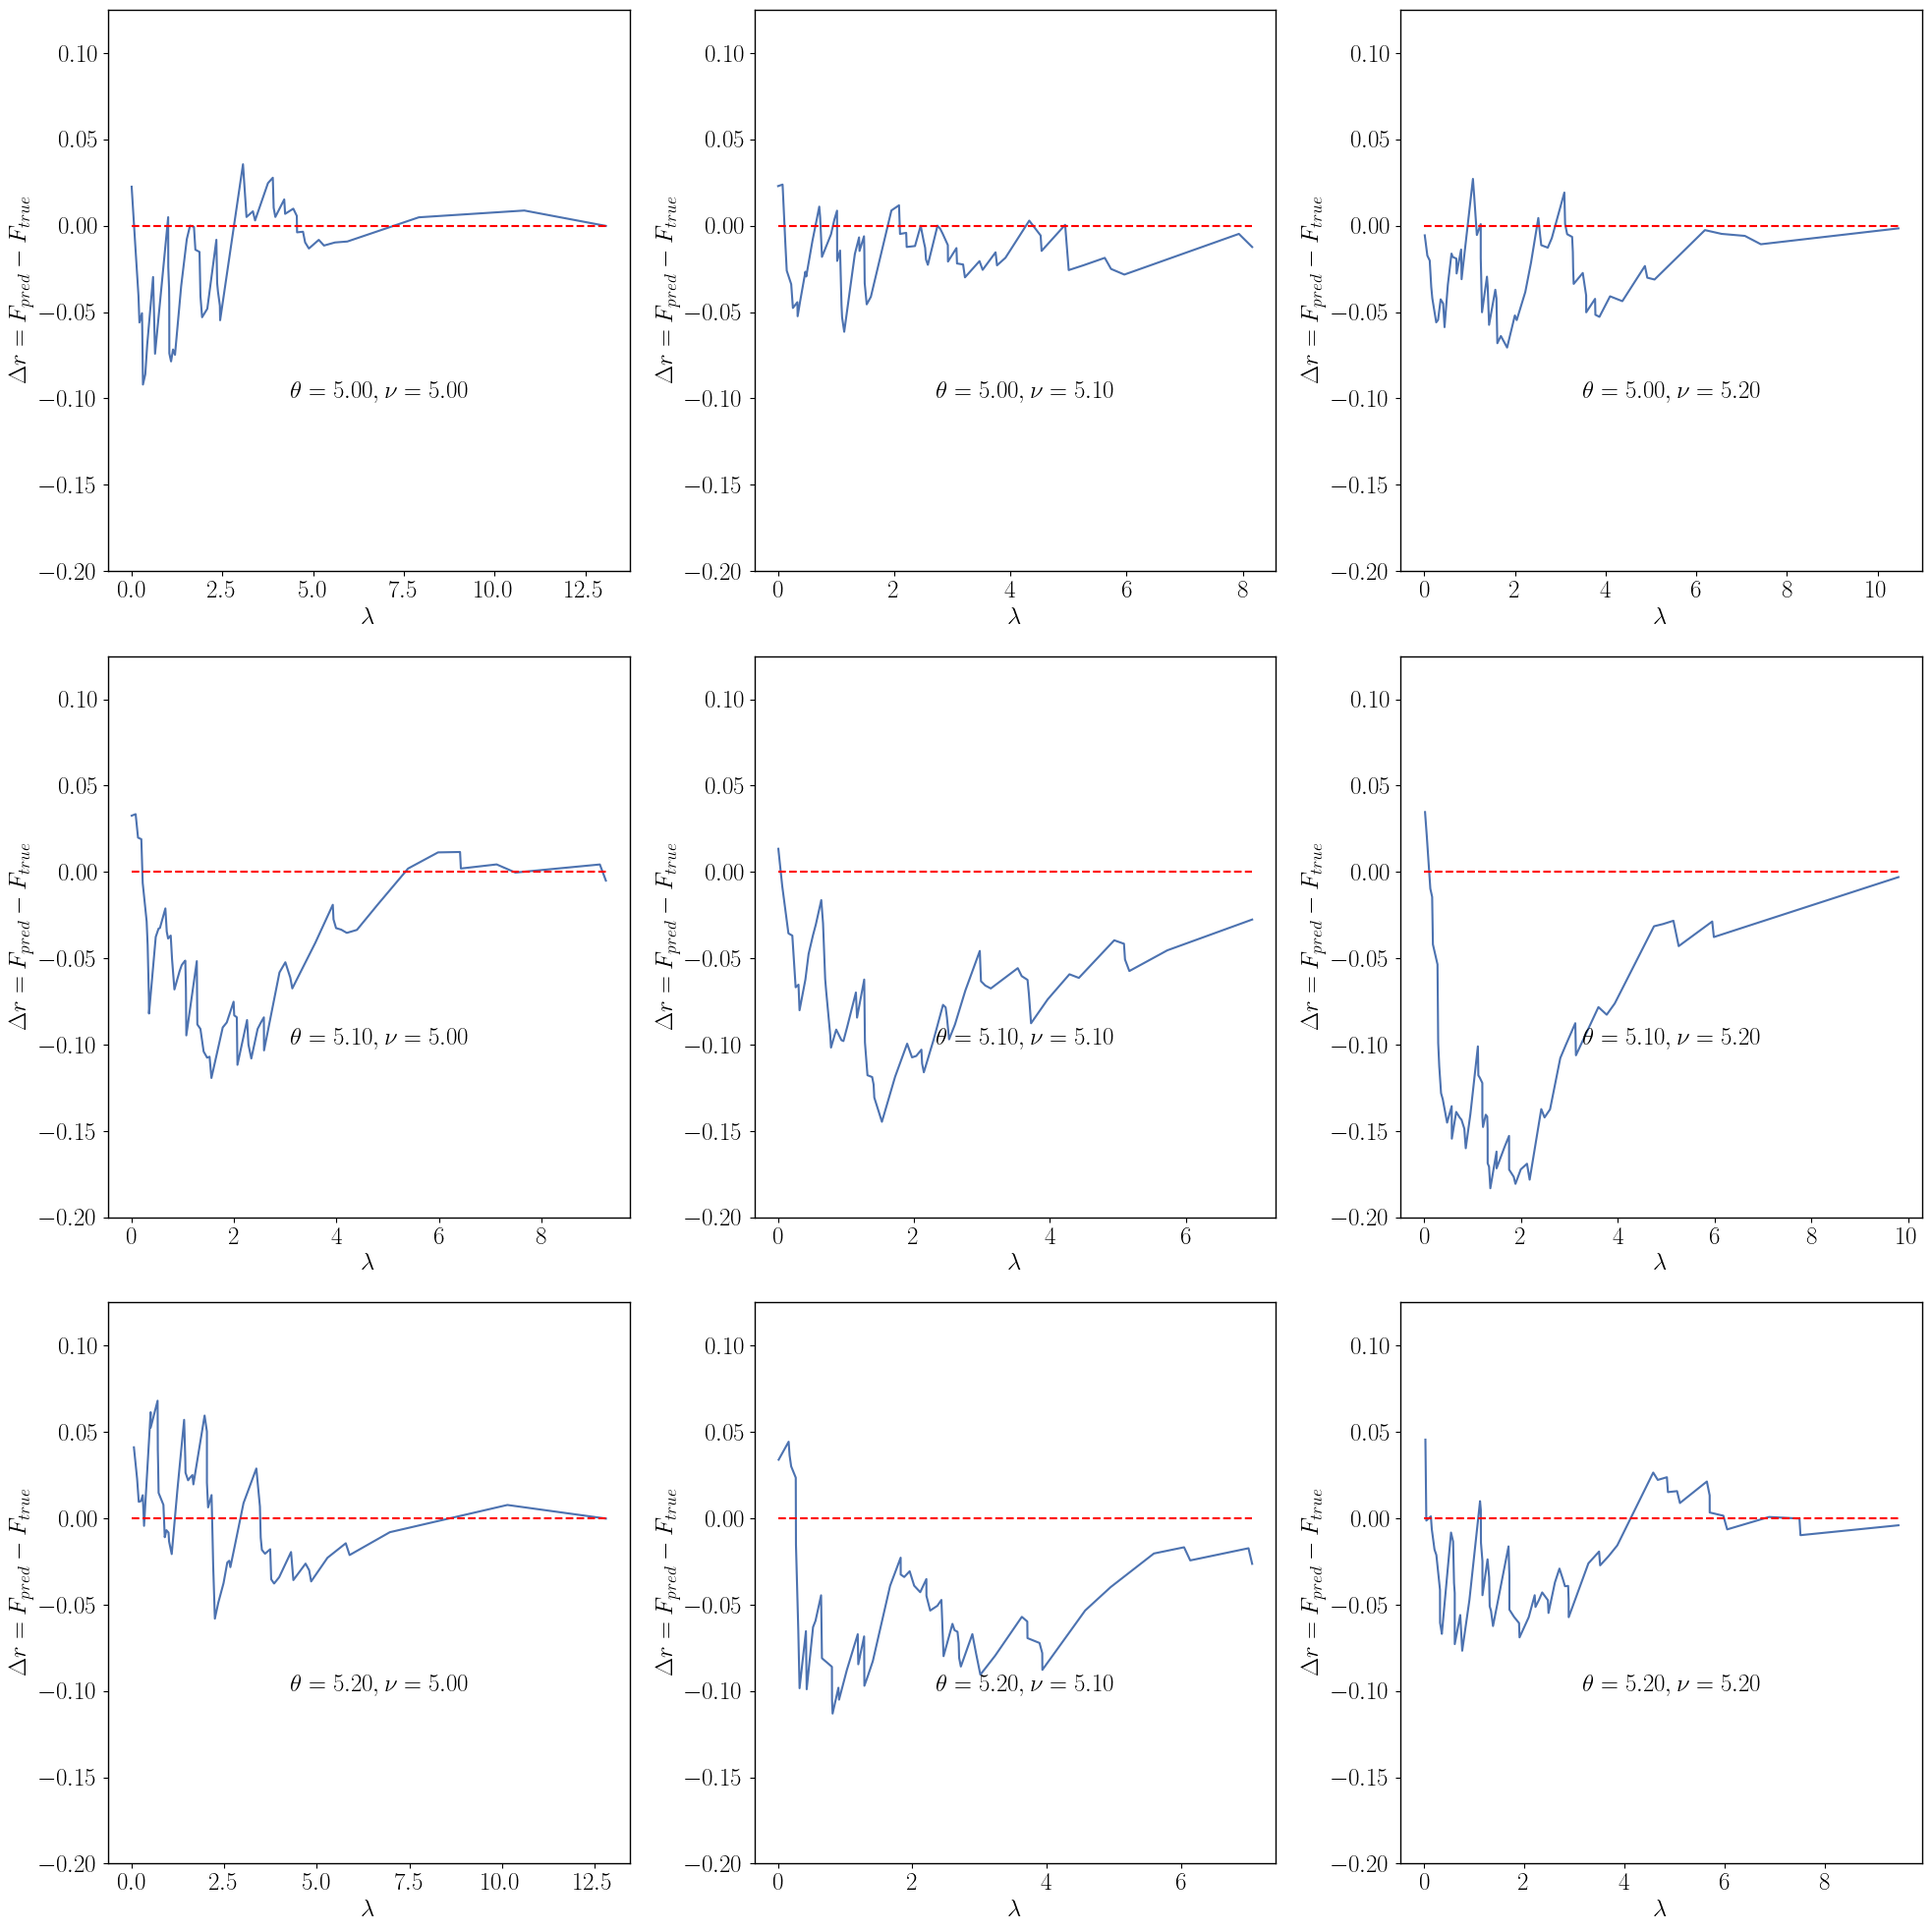

In [123]:
plot_q_deltar_points(nrows=3, ncols=3)

In [81]:
def generate_theta_nu_all_points(N_points):
    """non MLE evaluation data for the correction function at a single theta, nu point"""
    thetamin, thetamax  =0,20
    numin, numax  =0,20
    theta = st.uniform.rvs(thetamin, thetamax, size=N_points)
    nu = st.uniform.rvs(numin, numax, size=N_points)
    data = pd.DataFrame({'theta':theta, 'nu':nu})

    tmodel = TrainedModel(trained_SiLU_model_nonMLE)

    
    for rowind, row in data.iterrows():
        X = generate_X(theta=row['theta'], nu=row['nu'], N_points=100, MLE=False)
        lambda_ = X[:,2].flatten()
        lambda_ = precision(lambda_)
        data.loc[rowind, 'lambda'] =str(lambda_)
        
        
        true_CDF_l = []
        for lambda_val in lambda_:
            true_CDF_l.append(cdf(lambda_, lambda_val))
        true_CDF_l = precision(true_CDF_l)
        data.loc[rowind,'true_CDF'] = str(true_CDF_l)
        
        
        a = tmodel.cdf(X)
        a = precision(a)
        data.loc[rowind, 'pred_CDF'] =str(a)
        

    

    theta_l = []
    nu_l= []
    lambda_l = []
    pred_CDF_l = []
    true_CDF_l = []
    

    for row_ind, row in data.iterrows():
        lambda_ = eval(row['lambda'])
        lambda_l.append(lambda_)
        
        

        pred_CDF = eval(row['pred_CDF'])
        pred_CDF_l.append(pred_CDF)
        
        true_CDF = eval(row['true_CDF'])
        true_CDF_l.append(true_CDF)
        
        
        theta_r = np.full_like(lambda_, row['theta'])
        theta_l.append(theta_r)

        nu_r = np.full_like(lambda_, row['nu'])
        nu_l.append(nu_r)


    theta_l=np.array(theta_l).flatten()
    nu_l=np.array(nu_l).flatten()
    lambda_l=np.array(lambda_l).flatten()
    pred_CDF_l=np.array(pred_CDF_l).flatten()
    true_CDF_l=np.array(true_CDF_l).flatten()
    delta_r = pred_CDF_l-true_CDF_l
    
    
    # y = delta_C_l - min(delta_C_l)
    # y = y/np.std(y)

    data_flat=pd.DataFrame({'theta': theta_l,
                       'nu': nu_l,
                        'lambda':lambda_l,
                        'pred_CDF': pred_CDF_l,
                            'true_CDF':true_CDF_l,
                            'delta_r':delta_r,
                           # 'y':y
                           })
    
    # eval_array = data_flat[['theta', 'nu', 'lambda', 'true_CDF']].to_numpy()
    eval_array = data_flat[['lambda']].to_numpy()
    return data_flat, eval_array

In [36]:
df_all_points,_ =generate_theta_nu_all_points(N_points=10000)
df_all_points

,theta,nu,lambda,pred_CDF,true_CDF,delta_r
0,8.525602,1.714572,4.18692,0.83709,0.92,-0.08291
1,8.525602,1.714572,5.49478,0.92099,0.97,-0.04901
2,8.525602,1.714572,1.31615,0.43333,0.55,-0.11667
3,8.525602,1.714572,1.50544,0.47725,0.61,-0.13275
4,8.525602,1.714572,0.05075,0.06066,0.05,0.01066
...,...,...,...,...,...,...
999995,0.279940,5.277183,0.36068,0.17581,0.28,-0.10419
999996,0.279940,5.277183,0.07264,0.07063,0.13,-0.05937
999997,0.279940,5.277183,0.44063,0.21969,0.40,-0.18031
999998,0.279940,5.277183,0.46700,0.23103,0.41,-0.17897


# Train NN to fit residuals ($\Delta r$) 

In [110]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

def getwholedata_delta_r():
    """ Get train test split arrays"""
    
    # data = df_all_points
    data = df_single_point
        
    train_data, test_data = train_test_split(data, test_size=0.1)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='delta_r'
    # target='y'
    # source = ['theta','nu','theta_hat','N','M']

    # source = ['theta', 'nu', 'lambda', 'true_CDF']
    source = ['lambda']

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    # if valid:
        #if you want to also make a validation data set
    train_data, valid_data = train_test_split(train_data, test_size=0.015)
    valid_data = valid_data.reset_index(drop=True)
    valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    return train_t, train_x, test_t,  test_x, valid_t, valid_x

In [111]:
train_t, train_x, test_t,  test_x, valid_t, valid_x = getwholedata_delta_r()
N_Features = train_x.shape[1]

train_t shape =  (90000,) 

train_x shape =  (90000, 1) 



In [112]:
def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

In [142]:
from torch.autograd import Variable

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        
    def forward(self, x):
        return torch.sin(x)
    
    
class Delta_r_Model(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layer = nn.Linear(nfeatures, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight, gain=60)
                torch.nn.init.xavier_normal_(layer.weight, 
                                             gain=120
                                            )
                layers.append(layer)
                #batch normalization
                layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                #ReLU activation 
                # layers.append(nn.SiLU())
                layers.append(SinActivation())
                # layers.append(GroupSort(num_groups=1))
            else:
                #if this is not the first layer (we dont have layers)
                layer = nn.Linear(hidden_size, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight, gain=60)
                torch.nn.init.xavier_normal_(layer.weight, 
                                             # gain=60
                                            )
                layers.append(layer)
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                # layers.append(nn.SiLU())
                # layers.append(nn.Tanh())
                # layers.append(nn.ReLU())
                layers.append(SinActivation())
                
                #output layer:
        output_layer = nn.Linear(hidden_size, ntargets)
        torch.nn.init.xavier_uniform_(output_layer.weight)
        layers.append(output_layer) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        # layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)
    
def xavier_init_lstm(lstm):
    for name, param in lstm.named_parameters():
        if 'weight_ih' in name:
            nn.init.xavier_uniform_(param.data, gain=60)
        elif 'weight_hh' in name:
            nn.init.orthogonal_(param.data)
        elif 'bias' in name:
            nn.init.constant_(param.data, 0)
            
            
class Delta_r_Model_LSTM(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, 
                 ntargets, nlayers, hidden_size, dropout):
        super(Delta_r_Model_LSTM, self).__init__()
        self.hidden_size=hidden_size
        self.nlayers = nlayers
        
        self.lstm = nn.LSTM(input_size=nfeatures, hidden_size=hidden_size, num_layers=nlayers, batch_first=True)
        xavier_init_lstm(self.lstm)

        # self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.layer_1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.sin = SinActivation()
        
        self.output_layer = nn.Linear(hidden_size, ntargets)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)
        
    def forward(self, x):
        hidden_states = torch.zeros(self.nlayers, x.size(0), self.hidden_size).to(device)
        cell_states = torch.zeros(self.nlayers, x.size(0), self.hidden_size).to(device)
        # hidden_states=hidden_states.squeeze(0)
        # cell_states=cell_states.squeeze(0)
        hidden_states_shape = hidden_states.shape
        print('hidden_states_shape',hidden_states_shape)
        print('cell_states_shape',cell_states.shape)
        out, (hn, cn) = self.lstm(x, (hidden_states, cell_states) )
        out = out[:, -1, :]
        # hn =hn.view(-1, self.hidden_size)
        # hn = hn[:, -1, 3]
        batch_norm=False
        if batch_norm==True:
            out = out.permute(0,2,1)
            out = self.batchnorm(out)
            out = out.permute(0,2,1)
        # out = self.sin(hn)
        # out = self.sin(out)
        # out = self.output_layer(out[:, -1, :])
#         out = self.relu(hn)

        # out = self.layer_1(out)
        # out = self.relu(out)
        # out = self.output_layer(out)
        return out


In [143]:
def RMS(v):
    return (torch.mean(v**2)) ** 0.5

def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape

    # inv = torch.where(t !=0, 1/torch.abs(t), 1)
    
    # inv_RMS = torch.where(t !=0, 1/RMS(t), 1)
    
    return  torch.mean( (f - t)**2)

def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float().to(device)
        t = torch.from_numpy(targets).float().to(device)
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)
def train_delta_r(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    model = model.to(device)
    

    train_t, train_x, test_t,  test_x, _, _ = getwholedata_delta_r()

        
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float().to(device)
            t = torch.from_numpy(batch_t).float().to(device)    


        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, test_x[:n], test_t[:n])
            
            #using Ali's loader
            # acc_t = validate(model, avloss, batch_x, batch_t) 
            # acc_v = validate(model, avloss, batch_x_eval, batch_t_eval)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

In [144]:
@debug
def load_untrained_delta_r_model(PARAMS):
    """Load an untrained model (with weights initiatted) according to model paramateters in the 
    PARAMS dictionary

    Args:
        PARAMS (dict): dictionary of model/training parameters: i.e. hyperparameters and training parameters.

    Returns:
        utils.RegularizedRegressionModel object
    """
    model = Delta_r_Model(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"],
        # activation=PARAMS["activation"]
    )
    # model.apply(initialize_weights)
    print('INITIATED UNTRAINED MODEL:',
          # model
         )
    # print(model)
    return model
    

In [145]:
Delta_r_Model_PARAMS = {
"n_layers": int(6),
"hidden_size": int(4),
"dropout": float(0.13),
"NFEATURES":int(N_Features),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.00003),
'momentum':float(0.9),
'batch_size':int(60),
'n_iterations': int(1e6),
'traces_step':int(100),
'L2':float(0.1),
'MLE':False,
'with_lambda_D':True,
'pth_string':'Delta_r_nonMLE_SILU.pth'
}

In [146]:
untrained_Delta_r_model = load_untrained_delta_r_model(Delta_r_Model_PARAMS)

BATCHSIZE=Delta_r_Model_PARAMS["batch_size"]
traces_SiLU = ([], [], [], [])
traces_step = 2000
optimizer_name=Delta_r_Model_PARAMS["optimizer_name"]

optimizer_delta_r = getattr(torch.optim, str(optimizer_name))(untrained_Delta_r_model.parameters(), 
                                                           lr=Delta_r_Model_PARAMS["starting_learning_rate"])

traces_SiLU = train_delta_r(model=untrained_Delta_r_model, 
              optimizer=optimizer_delta_r, 
              avloss=average_quadratic_loss,
              batch_size=BATCHSIZE, 
              n_iterations=Delta_r_Model_PARAMS["n_iterations"], 
              traces=traces_SiLU, 
              step=traces_step, 
              window=200)

Calling load_untrained_delta_r_model({'n_layers': 6, 'hidden_size': 4, 'dropout': 0.13, 'NFEATURES': 1, 'activation': 'SiLU', 'optimizer_name': 'NAdam', 'starting_learning_rate': 3e-05, 'momentum': 0.9, 'batch_size': 60, 'n_iterations': 1000000, 'traces_step': 100, 'L2': 0.1, 'MLE': False, 'with_lambda_D': True, 'pth_string': 'Delta_r_nonMLE_SILU.pth'})
INITIATED UNTRAINED MODEL:
'load_untrained_delta_r_model' returned Delta_r_Model(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SinActivation()
    (3): Linear(in_features=4, out_features=4, bias=True)
    (4): SinActivation()
    (5): Linear(in_features=4, out_features=4, bias=True)
    (6): SinActivation()
    (7): Linear(in_features=4, out_features=4, bias=True)
    (8): SinActivation()
    (9): Linear(in_features=4, out_features=4, bias=True)
    (10): SinActivation()
    (11): Linear(in_features=4, out

KeyboardInterrupt: 

In [ ]:
df_single_point, eval_array = generate_theta_nu_single_point(theta=13, nu=10, N_points=100)
df_single_point 

# NN trained over all points

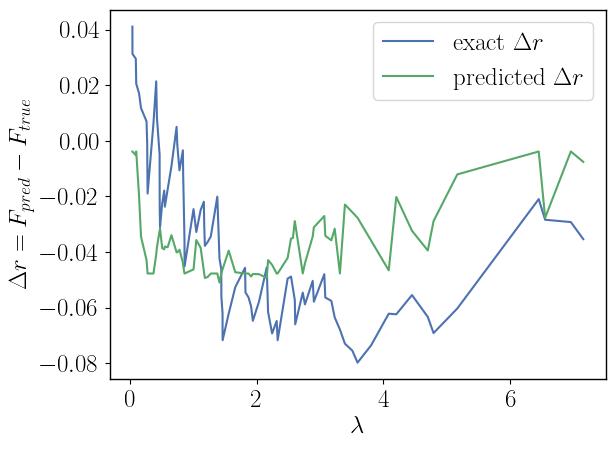

In [87]:
df_single_point, eval_array = generate_theta_nu_single_point(theta=13, nu=10, N_points=100)

eval_array_tensor = torch.Tensor(eval_array)
delta_r = df_single_point['delta_r'].to_numpy()
lambda_ = df_single_point['lambda'].to_numpy()
delta_r_hat = untrained_Delta_r_model(eval_array_tensor).detach().numpy()
plt.plot(lambda_, delta_r, label=r'exact $\Delta r$')
plt.plot(lambda_, delta_r_hat, label=r'predicted $\Delta r$')
plt.ylabel(r'$\Delta r = F_{pred}-F_{true}$')
plt.xlabel(r'$\lambda$')
plt.legend()
plt.show()

# NN trained over single point

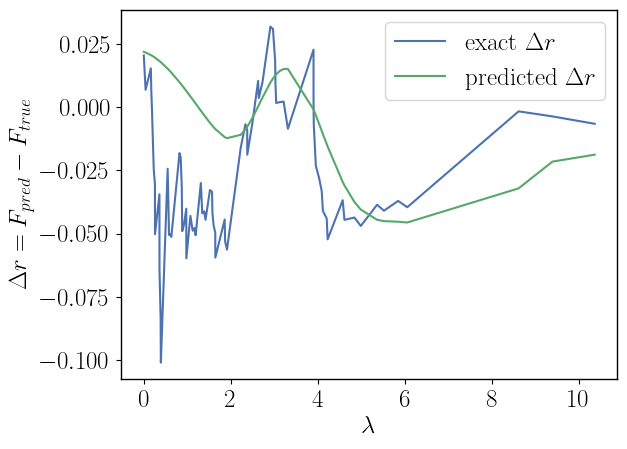

In [148]:
df_single_point, eval_array = generate_theta_nu_single_point(theta=19, nu=5, N_points=100)

eval_array_tensor = torch.Tensor(eval_array)
delta_r = df_single_point['delta_r'].to_numpy()
lambda_ = df_single_point['lambda'].to_numpy()
delta_r_hat = untrained_Delta_r_model(eval_array_tensor).detach().numpy()
plt.plot(lambda_, delta_r, label=r'exact $\Delta r$')
plt.plot(lambda_, delta_r_hat, label=r'predicted $\Delta r$')
plt.ylabel(r'$\Delta r = F_{pred}-F_{true}$')
plt.xlabel(r'$\lambda$')
plt.legend()
plt.show()